# 数值问题
#### 梯度爆炸和梯度消失
$1.5^{100}$ 约 $4*10^{17}$ 

$0.8^{100}$ 约 $2*10^{-10}$

d层网络做了d-t次矩阵乘法，带来梯度爆炸和梯度消失
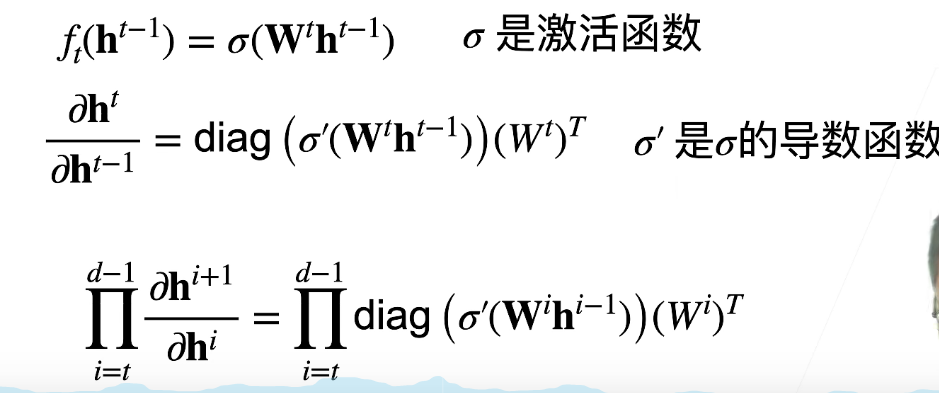
#### 梯度爆炸问题
- 考虑ReLU激活函数，在d-t深层时，梯度取决于Wi的连乘，如果数值大于1，出现梯度爆炸
- 值超过值域（infinity）
    - 对于16位浮点数尤为重要(区间取值6e-5-6e4)，16位比32位gpu上几乎快一倍
- 对学习率敏感
    - 如果学习率太大，导致大参数，导致更大梯度
    - 如果太小，训练无进展
    - 我们可能需要在训练过程中不断调整学习率
    
#### 梯度消失
- 如使用sigmoid函数，在距离0点越来越远的位置梯度都是小梯度，层数太深会导致梯度消失
- 梯度值变成0
    - 对16位浮点数尤为严重
- 训练没有进展
    - 不管如何选择学习率
- 对于底部层尤为严重（这里模型的从底向上）
    - 仅仅顶层训练较好
    - 无法让网络更深

#### 总结
- 当数值过大或者过小会导致数值问题
- 常发生在深度模型中，因为会n个数累乘

# 让训练更稳定
- 目标：让梯度值在合理的范围内
    - 如[1e-6,1e3]
- 将乘法变加法
    - ResNet，LSTM
- 归一化
    - 梯度归一化，梯度裁剪（强行限制在某个范围内）
- 合理的权重初始化和激活函数（本节介绍）

#### 使得每层方差是一个常数
- 将每层的输出和梯度都看做随机变量
- 让他们的均值和方差都保持一致
- 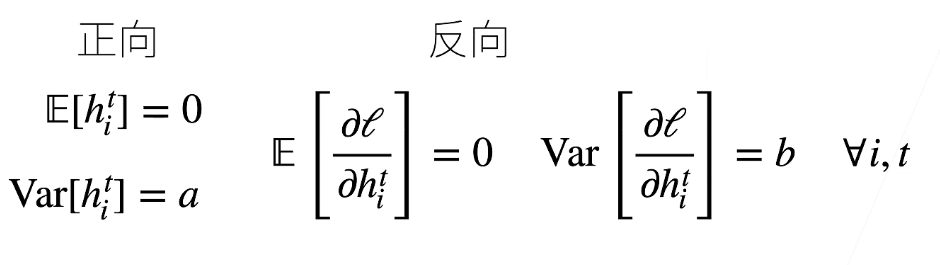
    - a b 都是常数
    
#### 权重初始化
- 在合理值区间内随机初始化参数
- 训练开始的时候更容易有数值不稳定
    - 远离最优解的地方损失函数表面可能很复杂
    - 最优解附近表面会比较平
- 使用N（0,0.01）来初始化对小网络没问题，但不能保证深度神经网络

#### Xavier推导过程
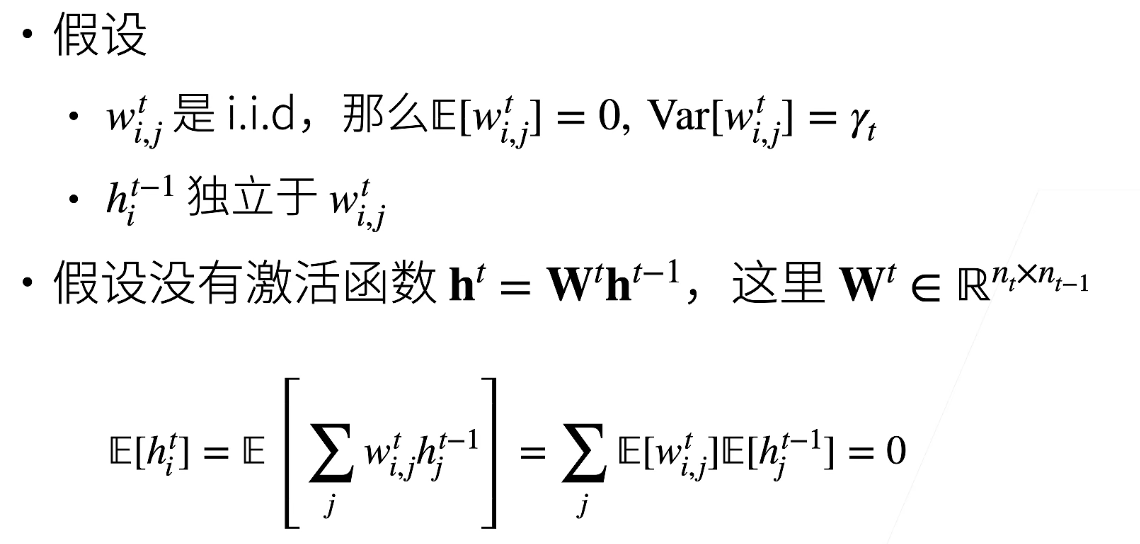
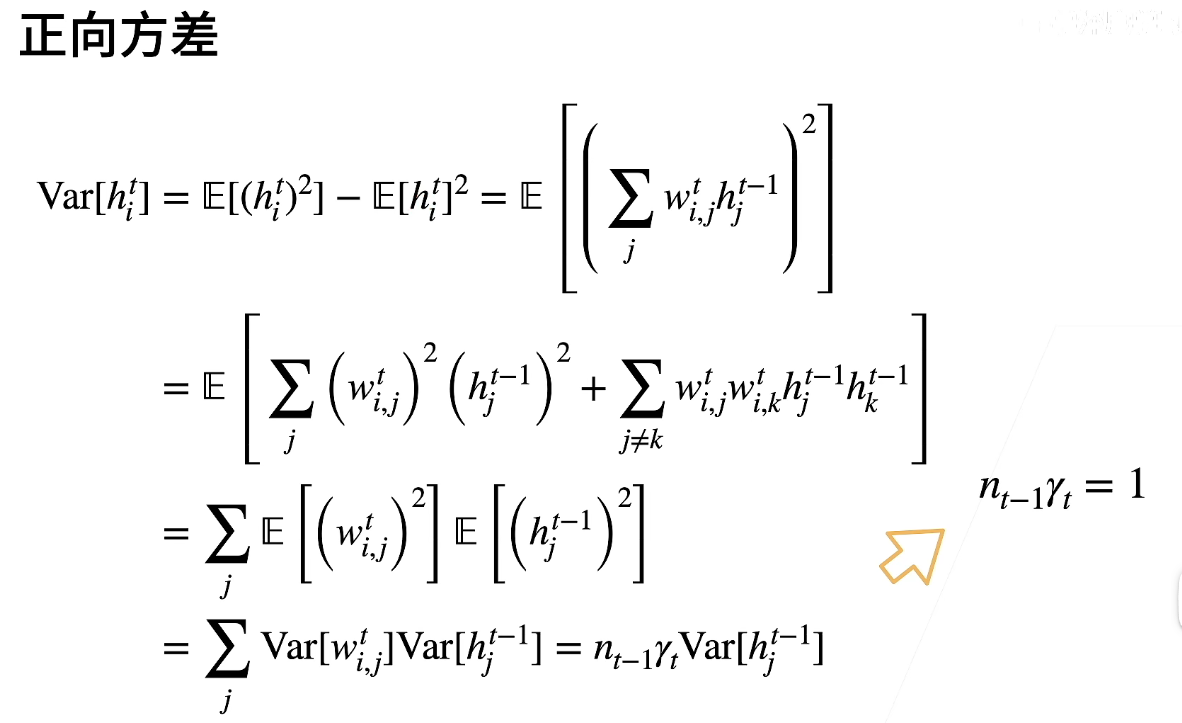
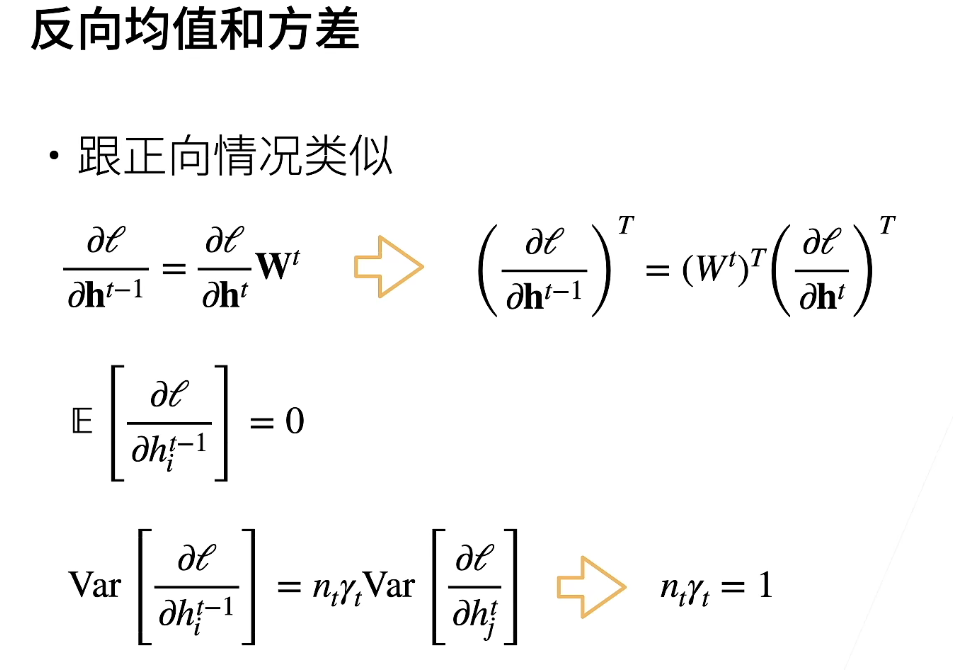
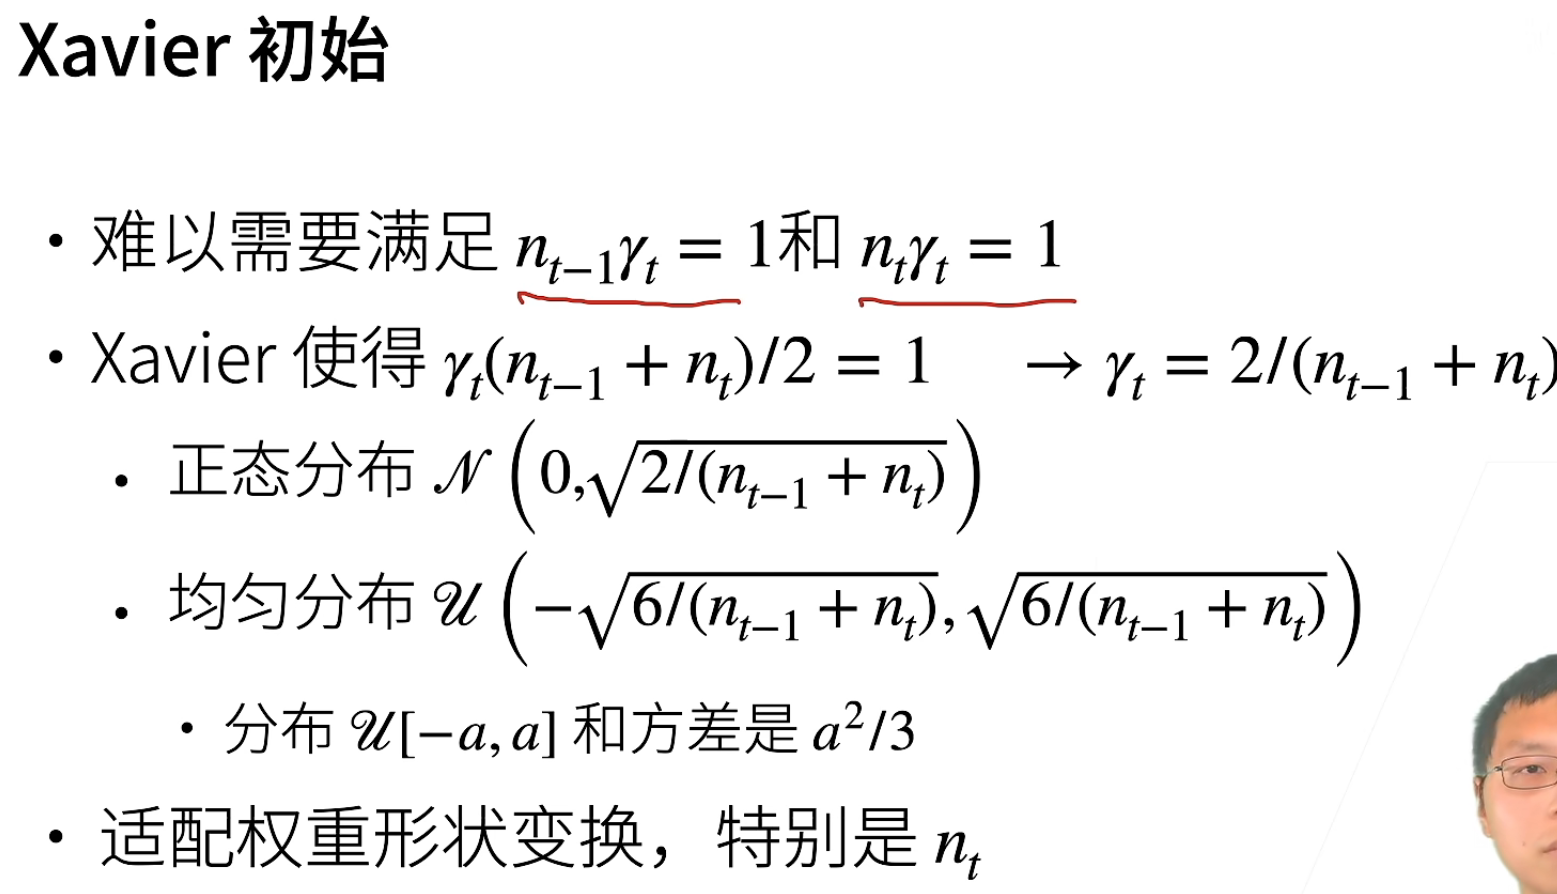

#### 激活函数选择
假设线性激活函数
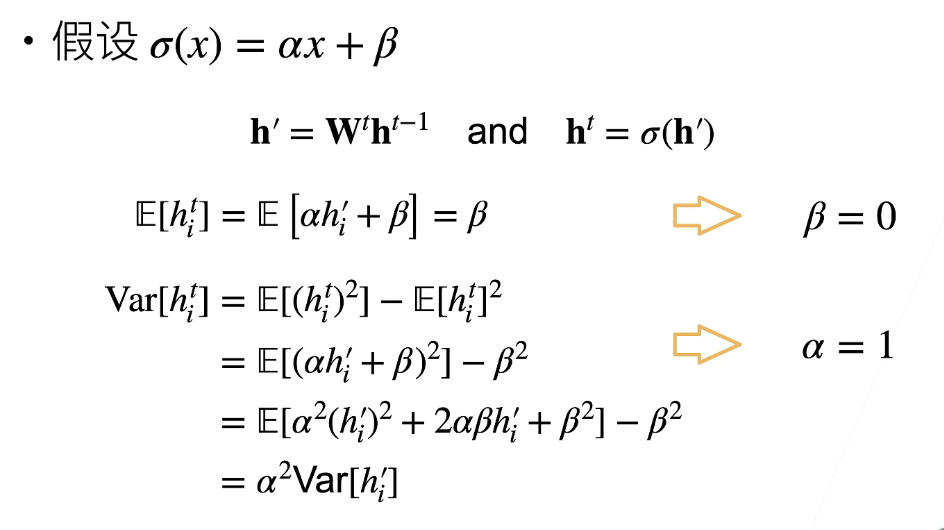


所以满足条件的函数a=0,b=1（原点附近，下面对常见函数进行泰勒展开从而选择能有效一定程度规避数值问题的函数）
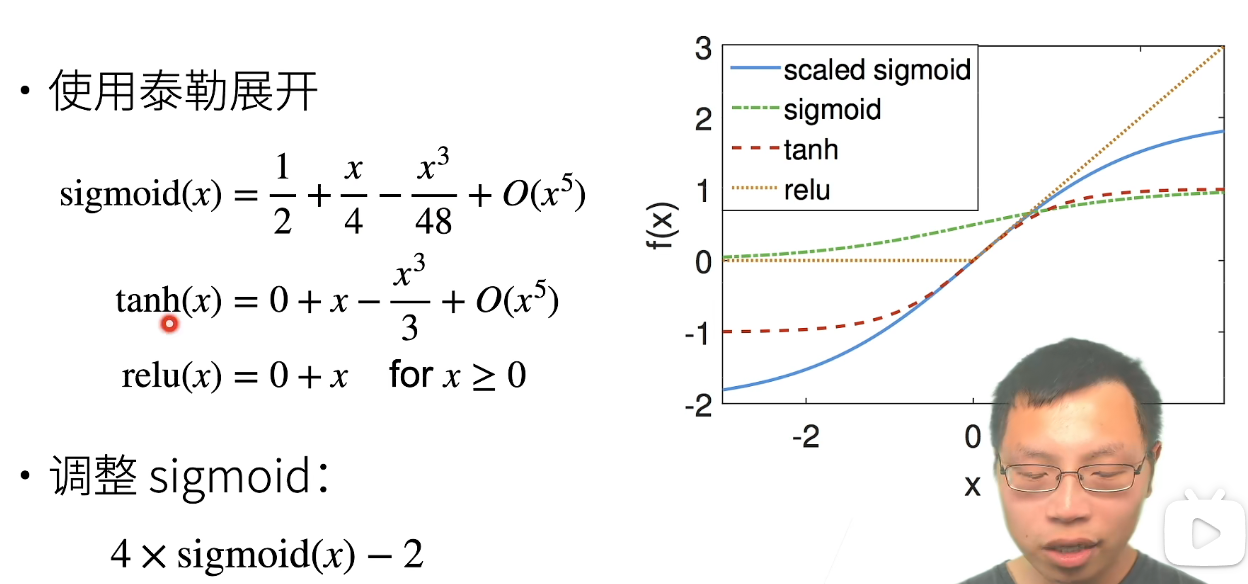

所以从数学上也侧面印证了relu和tanh激活函数在数值稳定性上的好处，一般使用relu即可，同时也表面，通过调整后的sigmoid也可以跟其他两个函数无差别

#### 总结
- 合理的权重初始化和激活函数的选取可以提高数值稳定性

# QA
#### nan inf如何产生？如何解决？
- nan一般除0产生，inf一般在第一次初始化，或者学习率太大导致，
- 可以一直调小学习率来尝试，或者初始化方差不要调太大，先慢慢调小使得不出现数值问题，然后再调大使得慢慢有进展
- 一般在网络中中间元素的值突然变成NAN，很可能发生了梯度爆炸

#### 如果训练开始在验证集精度增加，然后停在50%左右？
- 一般这种都是数值稳定性问题，如果降低学习率不能解决，说明模型本身存在数值稳定性问题

#### 输出或者参数符号正态分布有利于学习依据吗？
- 不一定需要时正态分布，只要保证均值0，方差固定在合理区间即可，满足条件什么分布都可以
- 这样做可能更多是为了算的方便

#### 为什么正态分布用的这么多？万能？
- 大数定理情况下，万物都是正态分布

#### 对每层数据进行均值0方差1 处理会不会损失网络表达，改变数据 特征？
- 不会，对于数学来讲，实数可以缩小可以放大没有绝对的大小一样，纯粹是为了计算方便进行缩小

In [1]:
# Kaggle 实战：房价预测
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [3]:
print(train_data.shape)
print(test_data.shape)
# train 含有label所以多一列

(1460, 81)
(1459, 80)


In [4]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [5]:
test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [6]:
# 每个样本中，第一列是ID，将其去掉
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:, 1:]))

In [7]:
all_features.shape

(2919, 79)

In [8]:
# 数值部分，将所有缺失值替换成均值，通过将特征重新缩放到0均值和单位方差来标准化数据
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 此时每一列在训练和测试集上一起做均值和方差，仅针对比赛，实际情况应该是训练集用训练的

In [9]:
all_features[numeric_features] = all_features[numeric_features].fillna(0) # 变成均值

In [10]:
# 处理离散值，用one-hot
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [17]:
# 下面将pandas转为NumPy格式，并将其转为张量
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                             dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), 
                           dtype=torch.float32)

In [31]:
# 训练
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

# 更关心相对误差 (y - h_hat) / y,解决这一问题的一种方法是用价格预测的对数来衡量
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

# 训练借助Adam

def train(net, train_features, train_labels, test_features, test_labels,
         num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features,  test_labels))
            
    return train_ls, test_ls


In [32]:
torch.cuda.is_available()

True

### K折交叉验证


In [33]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
            
    return X_train, y_train, X_valid, y_valid

In [34]:
# 返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_eopchs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                  weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                    xlabel='epoch', ylabel='emse', xlim=[1, num_epochs],
                    legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1])}'
              f'valid log rmse {float(valid_ls[-1]):f}')
    
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.14510582387447357valid log rmse 0.154391
fold 2, train log rmse 0.14392395317554474valid log rmse 0.124134
fold 3, train log rmse 0.14531177282333374valid log rmse 0.136026
fold 4, train log rmse 0.1406218707561493valid log rmse 0.175773
fold 5, train log rmse 0.13854390382766724valid log rmse 0.172984
fold 6, train log rmse 0.14387597143650055valid log rmse 0.120308
fold 7, train log rmse 0.14519724249839783valid log rmse 0.126639
fold 8, train log rmse 0.14238259196281433valid log rmse 0.150774
fold 9, train log rmse 0.13879135251045227valid log rmse 0.193062
fold 10, train log rmse 0.14468181133270264valid log rmse 0.139233
10-折验证： 平均训练误差log rmse： 0.142844,平均验证log rmse： 0.149332


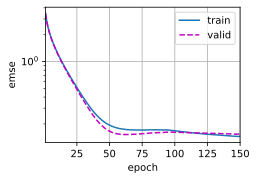

In [47]:
k, num_epochs, lr, weight_decay, batch_size = 10, 150, 3, 0, 32
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证： 平均训练误差log rmse： {float(train_l):f},'
      f'平均验证log rmse： {float (valid_l):f}')

train log rmse 0.138424


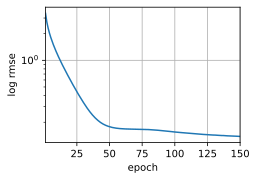

In [51]:
# 提交kaggle预测
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                    num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f"train log rmse {float(train_ls[-1]):f}")
    preds = net(test_features).detach().numpy()
    test_data['ScalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['ScalePrice']], axis=1)
    submission.to_csv('submission.csv',index=False)
    
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)
    